# CelebA 128x128 Experiments

In this notebook I investigate methods to train a DCGAN to generate 128x128 resolution images.

I try HDCGAN implementation with SeLU from the HDCGAN paper, increasing generator depth and finally increasing the generator kernel width.

Increasing kernel width is the most successful method.

In [8]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

In [9]:
#limit memory usage on gpus
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Note: Below Cell Defines Distribution Strategy
### Run the first cell for distributed training, or the 2nd cell for single GPU training

In [10]:
#set strategy for distributed mirrored strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
## set this strategy for single GPU training
strategy = tf.distribute.get_strategy()

### Tensorflow function to decode image and crop, resize and scale to tanh range for training

In [11]:
#augmentation function for tensorflow dataset
#reads image in, random flip left/right
#resize image
#cast image to tanh range (-1,1)
@tf.function
def prepare_image_celeb(img, dim=128):   
    img = tf.io.read_file(img) 
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.central_crop(img, 0.8)
    img = tf.image.resize(img,size=[dim,dim])
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

In [12]:
#Import DCGAN class
from SourceFiles.ModelSourceFiles.DCGAN import *

#Import Utilities
from SourceFiles.Utilities.Utils import *

### Below cell creates CelebA dataset
Batch size is number of gpus * per gpu batch size.

Tensorflow datasets can batch and prepare data asynchronously, hence we set the num_parallel_calls to use all available cores. Batch, shuffle and prefetch so that CPU prepares batches why GPU trains

cache() stores whole dataset in memory after the first pass

In [13]:
#create dataset 
BUFFER_SIZE = 10000 ## number items to buffer
BATCH_SIZE = 128 * strategy.num_replicas_in_sync #batch size * number of gpus
img_files = tf.io.gfile.glob('celeb/img_align_celeba/*.jpg') # read file names
celeb_train = tf.data.Dataset.from_tensor_slices(img_files) # create dataset
celeb_train = celeb_train.map(prepare_image_celeb, num_parallel_calls=tf.data.experimental.AUTOTUNE) #parallel calls to take advantage of multi cpu cores
celeb_train = celeb_train.shuffle(BUFFER_SIZE) #shuffle 
celeb_train = celeb_train.batch(BATCH_SIZE) #batch
celeb_train = celeb_train.prefetch(tf.data.experimental.AUTOTUNE)
celeb_train = celeb_train.cache() #cache to speed up training time

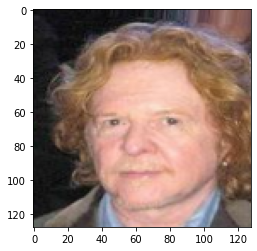

In [7]:
#Take one image from the dataset, and show after recasting back to RGB range
img = celeb_train.take(1)
for each in img:
    each = each.numpy()
    plt.imshow((each[1, :, :, :] * 127.5 + 127.5).astype(np.uint8))
plt.show()

# Testing HDCGAN Model with  SeLU Activation
#### In the cell below I test using selu activation in the generator, cited as a successful method in the HDCGAN paper.

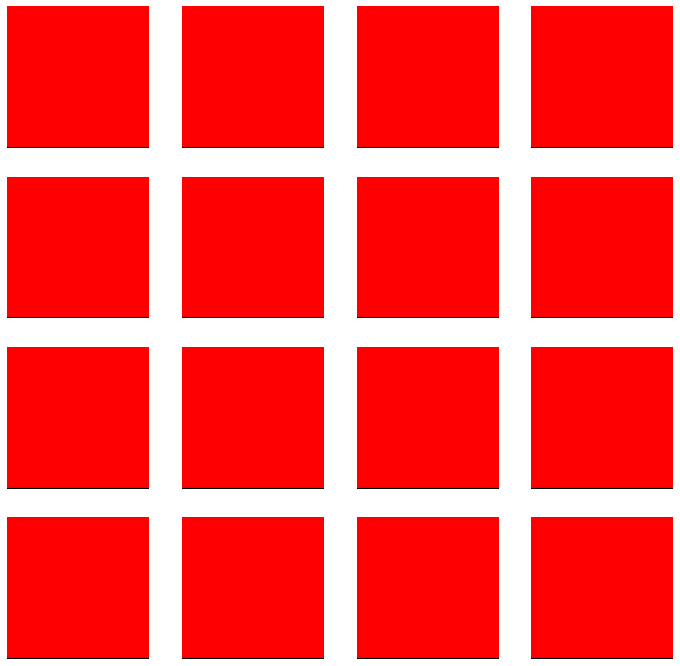

817/817 [==============================] - 927s 1s/step - Generator_Loss: 1374.7879 - Discriminator_Real_Loss: 0.0000e+00 - Discriminator_Generator_Loss: 0.0000e+00 - Average_Discriminator_Loss: 0.0000e+00
CPU times: user 22min 28s, sys: 17min 35s, total: 40min 3s
Wall time: 3h 54min


In [14]:
%%time
#HDCGAN Model with selu activation

with strategy.scope():
    # Define optimizers for gen and discriminator
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #parameters according to original paper
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    
    #defines architecture of the generator
    #number of filters dictates the number of deconv blocks
    #must set activation
    gen_dict = {'num_latent':100, #number of latent variables
             "filter_num":[768,512,384,256,256],
             "filter_size":[4,4,4,4,4], # Paper mentions filter sizes of 4x4
             "strides":[2,2,2,2,2], # Number of deconv blocks to achieve 128x128 image size
             'dense':(4,4,1024),  # num of nodes in the project and reshape
             'activation':'selu', # Selu activation as per the paper
             'out_channels':3,
             'latent_distribution':'normal'} #latent distribution normal(0,0.2) or uniform(-1,1)
    
    #defines architecture of the discriminator
    disc_dict = {"filter_num": [128, 256, 512],
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu', #leakyrelu activation
             'out_channels': 3, #number of channels 3 for rgb
             'dropout':0, #dropout to use in top 
             'random_noise':False} #gaussian noise
    
    #create model
    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=128, 
                  model_name='Celeb_Selu_128_128_100_normal', distribute=True)
    
    #comiple model with optimizer and distributed loss
    model.compile(generator_optimizer, discriminator_optimizer, 
                  tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     #label_smoothing=0.1,
                                                     reduction=tf.keras.losses.Reduction.NONE))
    #set the callbacks custom and tensorboard
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
    
    #train model
    selu_history = model.fit(x=celeb_train, epochs=15, callbacks=[save_callback,tensorboard_callback],shuffle=True)
    

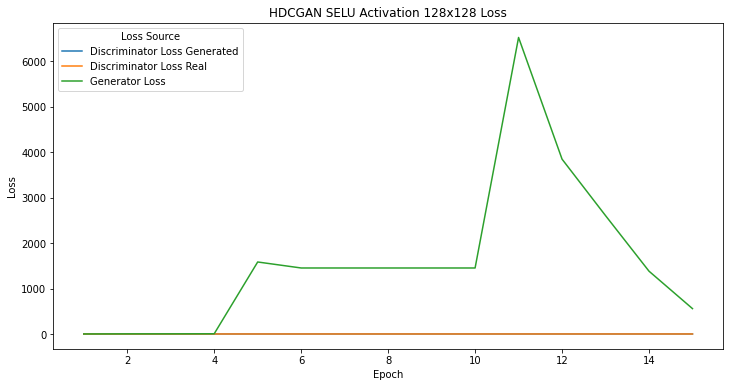

In [27]:
#Call custom function for graphs
Show_and_save_loss_graph(model_history=selu_history, name='SELU_128_128_loss_2', title='HDCGAN SELU Activation 128x128 Loss')

# High Resolution Via Increasing Generator Depth
#### In the cell below I test using increased depth in the generator and the discriminator to generate higher resolution images. 

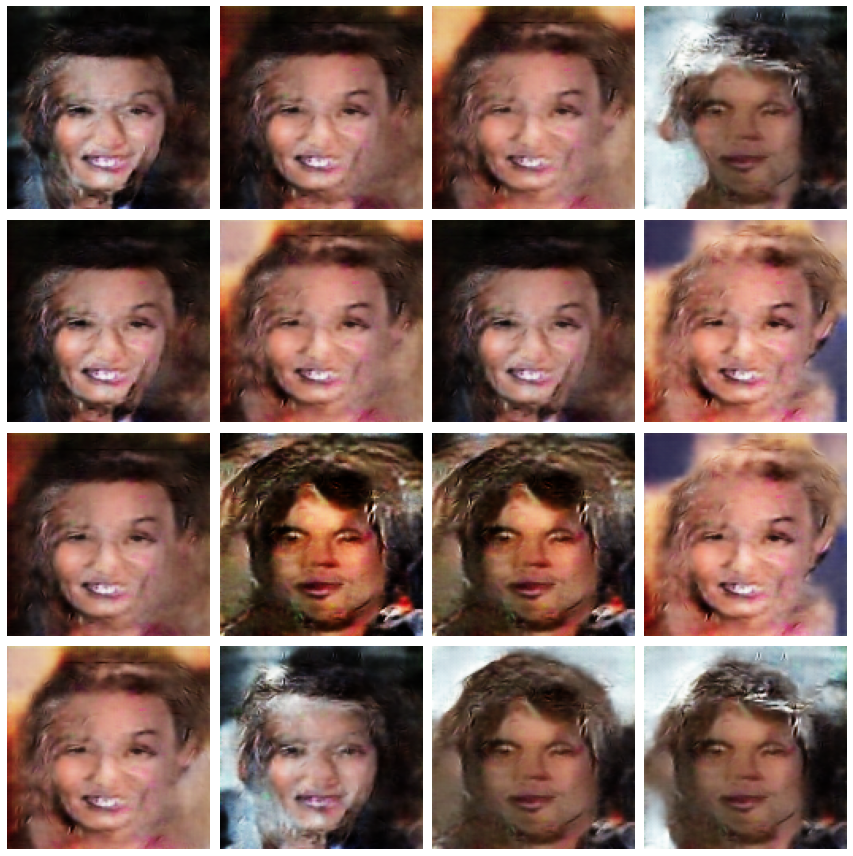

817/817 [==============================] - 1006s 1s/step - Generator_Loss: 2.2032 - Discriminator_Real_Loss: 0.2248 - Discriminator_Generator_Loss: 0.1593 - Average_Discriminator_Loss: 0.1921 - Discriminator_Generator_Accuracy: 0.8741 - Discriminator_Real_Accuracy: 0.7749
CPU times: user 53min 38s, sys: 28min 8s, total: 1h 21min 47s
Wall time: 8h 25min 5s


In [16]:
%%time
#DCGAN 128x128
#Increased Depth Model 
with strategy.scope():
    # Define optimizers for gen and discriminator
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #learning rate by x10
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    
        
    #defines architecture of the generator
    #number of filters dictates the number of deconv blocks
    #must set activation
    gen_dict = {'num_latent':100,
             "filter_num":[768,512,384,256,128], #Adding more deconvolution blocks
             "filter_size":[8,5,5,5,5], 
             "strides":[2,2,2,2,2],
             'dense':(4,4,1024), 
             'activation':'relu', 
             'out_channels':3,
             'latent_distribution':'normal'}
    
    disc_dict = {"filter_num": [128, 256, 512, 768], #Increasing conv blocks with deconv blocks
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu',
             'out_channels': 3,
             'dropout':0,
             'random_noise':False}

    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=128, model_name='Celeb_Normal_100_128x128_DCGAN_depth', distribute=True)
    model.compile(generator_optimizer, discriminator_optimizer, 
                  tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     #label_smoothing=0.1,
                                                     reduction =tf.keras.losses.Reduction.NONE))
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
    DCGANHistory_Depth = model.fit(x=celeb_train, epochs=30, callbacks=[save_callback,tensorboard_callback],shuffle=True)
    

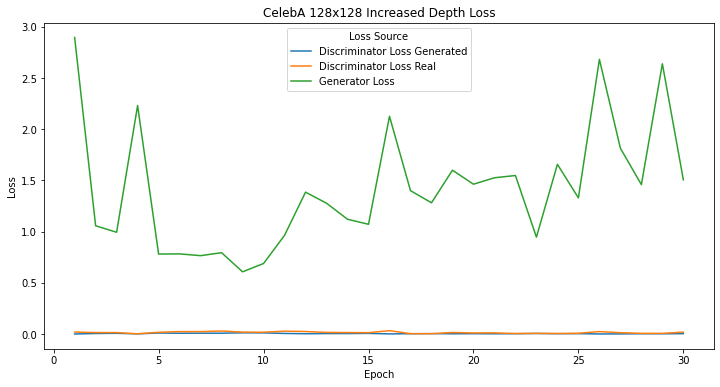

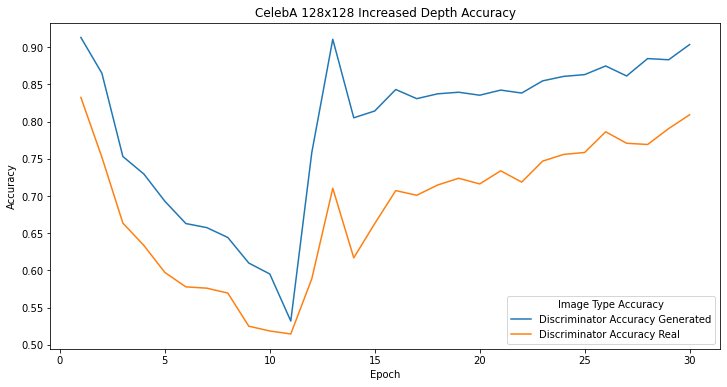

In [17]:
#Custom functions for graphing
Show_and_save_loss_graph(model_history=DCGANHistory_Depth, name='Celeb 128x128 Depth', title='CelebA 128x128 Increased Depth Loss')
Show_and_save_accuracy_graph(model_history=DCGANHistory_Depth, name='CelebA 128x128 Depth Accuracy', title='CelebA 128x128 Increased Depth Accuracy')

# High Resolution Via Increasing Kernel Width
#### Below is the most successful attempt at increasing image resolution. The key appears to be maintaining DCGAN depth to 5 deconvolution blocks and increasing the project and reshape kernel width.

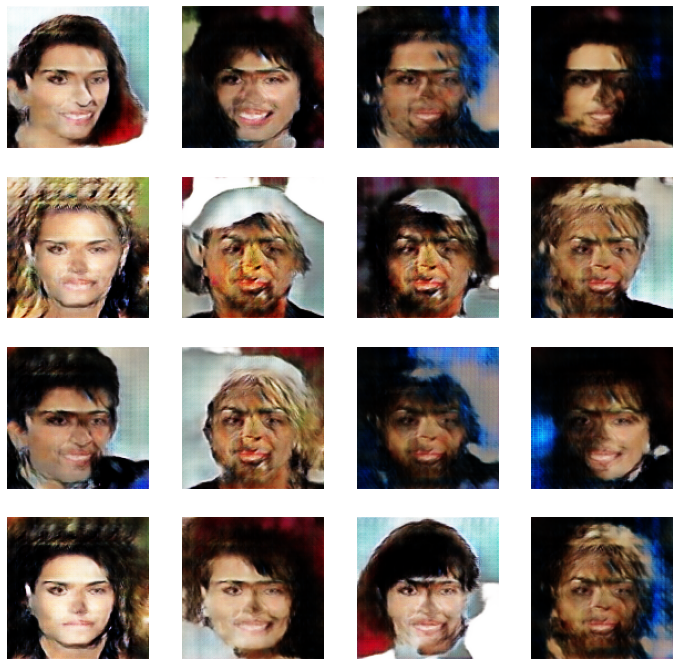

1089/1089 [==============================] - 2055s 2s/step - Generator_Loss: 0.8341 - Discriminator_Real_Loss: 0.3167 - Discriminator_Generator_Loss: 0.3578 - Average_Discriminator_Loss: 0.3373 - Discriminator_Generator_Accuracy: 0.5916 - Discriminator_Real_Accuracy: 0.5158
CPU times: user 58min 23s, sys: 31min 44s, total: 1h 30min 7s
Wall time: 9h 9min 22s


In [7]:
%%time
#DCGAN 128x128 Larger Kernel at the projection level, 

with strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #learning rate by x10
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    gen_dict = {'num_latent':100,
             "filter_num":[768,512,384,256],
             "filter_size":[8,5,5,5], 
             "strides":[2,2,2,2],
             'dense':(8,8,1024), #Increase kernel width by a factor of 2
             'activation':'relu', 
             'out_channels':3,
             'latent_distribution':'normal'}
    
    disc_dict = {"filter_num": [128, 256, 512], #Maintain discriminator depth
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu',
             'out_channels': 3,
             'dropout':0.3,
             'random_noise':False}

    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=96, model_name='Celeb_Normal_100_128x128_16_kernel_DCGAN', distribute=True)
    model.compile(generator_optimizer, discriminator_optimizer, 
                  tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     #label_smoothing=0.1,
                                                     reduction =tf.keras.losses.Reduction.NONE))
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
    DCGANHistory = model.fit(x=celeb_train, epochs=16, callbacks=[save_callback,tensorboard_callback],shuffle=True)
    

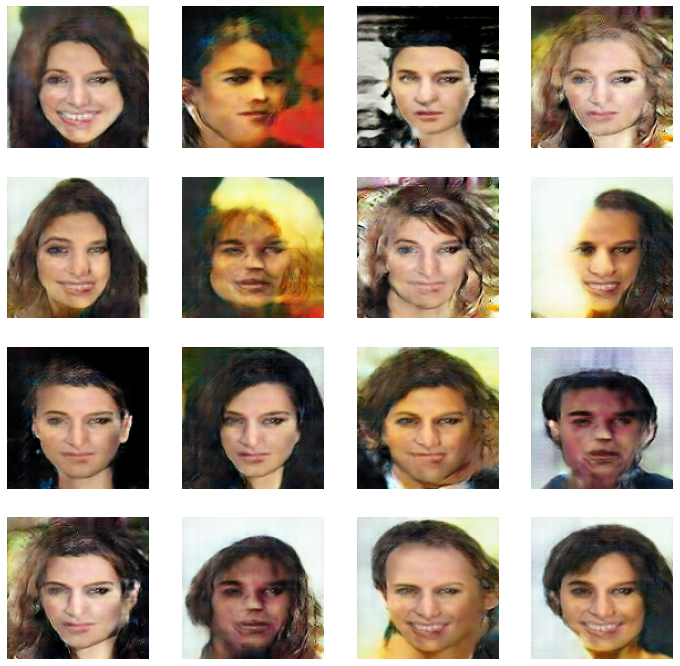

1089/1089 [==============================] - 2054s 2s/step - Generator_Loss: 0.8866 - Discriminator_Real_Loss: 0.3582 - Discriminator_Generator_Loss: 0.4688 - Average_Discriminator_Loss: 0.4135 - Discriminator_Generator_Accuracy: 0.5267 - Discriminator_Real_Accuracy: 0.4466


In [10]:
with strategy.scope():
    DCGANHistory_2 = model.fit(x=celeb_train, epochs=3, callbacks=[save_callback,tensorboard_callback],shuffle=True)

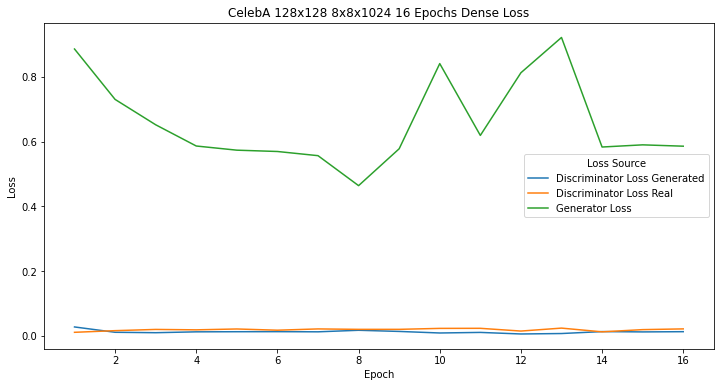

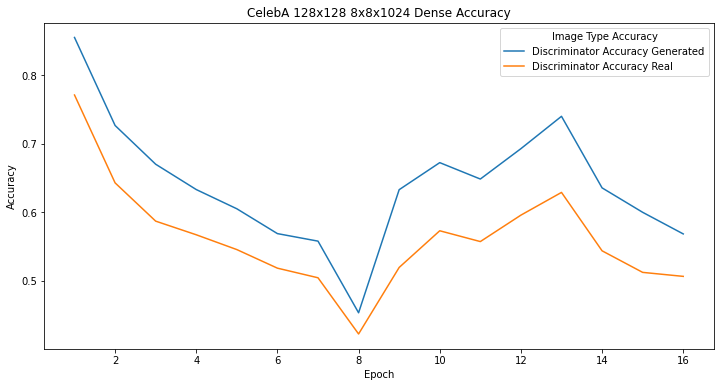

In [9]:
from Utils import *
Show_and_save_loss_graph(model_history=DCGANHistory, name='Celeb 128x128 Kernel Width', title='CelebA 128x128 8x8x1024 16 Epochs Dense Loss')
Show_and_save_accuracy_graph(model_history=DCGANHistory, name='CelebA 128x128 8x8x1024 Dense Accuracy', title='CelebA 128x128 8x8x1024 Dense Accuracy')